In [4]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.dirname(os.getcwd()))
import tensorflow as tf
import numpy as np
from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset.utils import  frame_utils
import tensorflow as tf

from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset.utils import  frame_utils

import matplotlib.pyplot as plt
from matplotlib import patches

import numpy as np
import math
import open3d as o3d
import alphashape
from PIL import Image
import cv2
import time

In [108]:
training_files = ['Data/unprocessed/training/segment-15832924468527961_1564_160_1584_160_with_camera_labels.tfrecord']
dataset = tf.data.TFRecordDataset(training_files, buffer_size=tf.constant(int(pow(10,6)), tf.int64), num_parallel_reads=16)
OUTPUT_PATH = 'Data/darknet-data'
img_id = len(os.listdir(f'{OUTPUT_PATH}/obj')) // 2

print('Processing training data')
nb_pedestrians = 0
MAX_PEDESTRIANS = 20000

data = None
for datapoints in dataset.skip(100):
    data = datapoints
    break
frame = open_dataset.Frame()
frame.ParseFromString(bytearray(data.numpy()))
image = tf.io.decode_jpeg(frame.images[0].image).numpy()
(range_images, camera_projections, _, range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(frame)
points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose)
points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose,
    ri_index=1)

# 3d points in vehicle frame.
points_all = np.concatenate(points, axis=0)
points_all_ri2 = np.concatenate(points_ri2, axis=0)
# camera projection corresponding to each point.
cp_points_all = np.concatenate(cp_points, axis=0)
cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)

all_points = np.append(points_all, points_all_ri2, axis=0)
all_points_cp = np.append(cp_points_all, cp_points_all_ri2, axis=0)

front_points = np.array([point for (point, cp) in zip(all_points, all_points_cp) if cp[0] == 1 or cp[3] == 1])

front_cp_points = np.array([cp[:3] if cp[0] == 1 else cp[3:] for cp in all_points_cp if cp[0] == 1 or cp[3] == 1])[:,1:3]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(front_points)
mask = np.zeros(image.shape[:2], dtype="uint8")

Processing training data


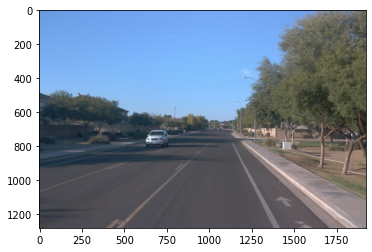

In [109]:
plt.imshow(image)

In [110]:
start_time = time.time()
_, inliers = pcd.segment_plane(distance_threshold=0.1, ransac_n=4, num_iterations=250)

front_cp_points_no_road = np.delete(front_cp_points, inliers, axis=0)

mask[:] = 0
for point in front_cp_points_no_road:
    mask = cv2.circle(mask, point, 20, (255, 255, 255), -1) 

image = cv2.bitwise_and(image, image, mask=mask)
end_time = time.time()
print(end_time - start_time)

0.05833292007446289


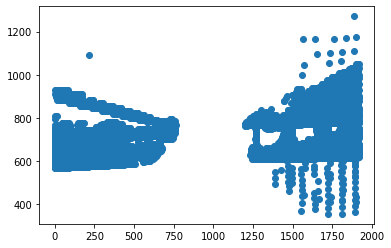

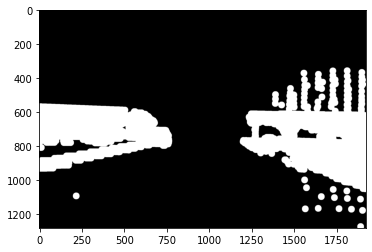

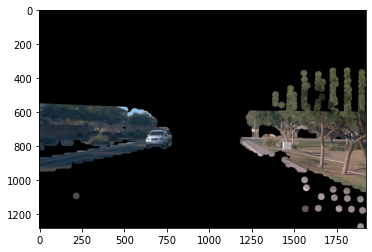

In [112]:
plt.scatter(front_cp_points_no_road[:, 0], front_cp_points_no_road[:, 1])
plt.show()
plt.imshow(mask, cmap='gray')
plt.show()
plt.imshow(image)

0.06118130683898926


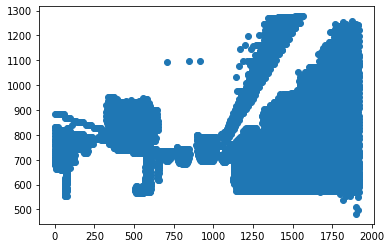

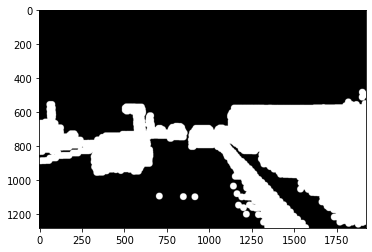

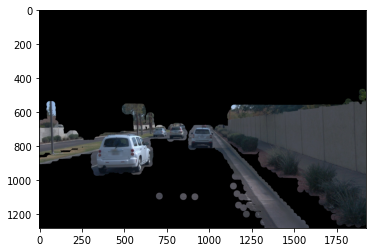

In [8]:
files = ['Data/unprocessed/training/' + file for file in os.listdir('Data/unprocessed/training')]
dataset = tf.data.TFRecordDataset(files, buffer_size=int(pow(10,6)), num_parallel_reads=16)
for data in dataset.skip(2):
   frame = open_dataset.Frame()
   frame.ParseFromString(bytearray(data.numpy()))
   image = tf.io.decode_jpeg(frame.images[0].image).numpy()
   (range_images, camera_projections, _, range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(frame)
   points, cp_points = frame_utils.convert_range_image_to_point_cloud(
      frame,
      range_images,
      camera_projections,
      range_image_top_pose)
   points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
      frame,
      range_images,
      camera_projections,
      range_image_top_pose,
      ri_index=1)

   # 3d points in vehicle frame.
   points_all = np.concatenate(points, axis=0)
   points_all_ri2 = np.concatenate(points_ri2, axis=0)
   # camera projection corresponding to each point.
   cp_points_all = np.concatenate(cp_points, axis=0)
   cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)

   all_points = np.append(points_all, points_all_ri2, axis=0)
   all_points_cp = np.append(cp_points_all, cp_points_all_ri2, axis=0)

   front_points = np.array([point for (point, cp) in zip(all_points, all_points_cp) if cp[0] == 1 or cp[3] == 1])

   front_cp_points = np.array([cp[:3] if cp[0] == 1 else cp[3:] for cp in all_points_cp if cp[0] == 1 or cp[3] == 1])[:,1:3]

   pcd = o3d.geometry.PointCloud()
   pcd.points = o3d.utility.Vector3dVector(front_points)
   mask = np.zeros(image.shape[:2], dtype="uint8")

   start_time = time.time()
   _, inliers = pcd.segment_plane(distance_threshold=0.1, ransac_n=4, num_iterations=250)

   front_cp_points_no_road = np.delete(front_cp_points, inliers, axis=0)

   mask[:] = 0
   for point in front_cp_points_no_road:
      mask = cv2.circle(mask, point, 20, (255, 255, 255), -1) 

   image = cv2.bitwise_and(image, image, mask=mask)
   end_time = time.time()
   print(end_time - start_time)
   plt.scatter(front_cp_points_no_road[:, 0], front_cp_points_no_road[:, 1])
   plt.show()
   plt.imshow(mask, cmap='gray')
   plt.show()
   plt.imshow(image)
   break